## This project uses Linear Regression to predict the number of bike share

### Import libraries and set some secret variable

In [41]:
from ucimlrepo import fetch_ucirepo 

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE
from sklearn.linear_model import LinearRegression



curious_me = False

### Read the data

In [3]:
# fetch dataset 
bike_sharing = fetch_ucirepo(id=275) 

In [4]:
# data (as pandas dataframes) 
X = bike_sharing.data.features 
y = bike_sharing.data.targets 

# convert y to shape of (samples, )
y = np.array(object=y)
y = y.ravel()
  
# metadata 
# print(bike_sharing.metadata) 
  
# variable information 
print(bike_sharing.variables) 

          name     role         type demographic  \
0      instant       ID      Integer        None   
1       dteday  Feature         Date        None   
2       season  Feature  Categorical        None   
3           yr  Feature  Categorical        None   
4         mnth  Feature  Categorical        None   
5           hr  Feature  Categorical        None   
6      holiday  Feature       Binary        None   
7      weekday  Feature  Categorical        None   
8   workingday  Feature       Binary        None   
9   weathersit  Feature  Categorical        None   
10        temp  Feature   Continuous        None   
11       atemp  Feature   Continuous        None   
12         hum  Feature   Continuous        None   
13   windspeed  Feature   Continuous        None   
14      casual    Other      Integer        None   
15  registered    Other      Integer        None   
16         cnt   Target      Integer        None   

                                          description units mis

In [5]:
print(X.head())
print(X.shape, y.shape)

       dteday  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  \
0  2011-01-01       1   0     1   0        0        6           0           1   
1  2011-01-01       1   0     1   1        0        6           0           1   
2  2011-01-01       1   0     1   2        0        6           0           1   
3  2011-01-01       1   0     1   3        0        6           0           1   
4  2011-01-01       1   0     1   4        0        6           0           1   

   temp   atemp   hum  windspeed  
0  0.24  0.2879  0.81        0.0  
1  0.22  0.2727  0.80        0.0  
2  0.22  0.2727  0.80        0.0  
3  0.24  0.2879  0.75        0.0  
4  0.24  0.2879  0.75        0.0  
(17379, 13) (17379,)


### Drop the dteday and the yr features
We drop the `dteday` (the exact date) feature since it only gives the exact date. Also, the data type is not train-able.

We drop the `yr` (year) feature since it is either 0 or 1 to indicate if it is the first or the second year of the data collection. If we want to further use the model to predict the count of total rental bikes, then the input year will be 2, 3, 4, etc, which are unseen. Also, two years (either 0 or 1) are not enough to predict the future. 

In [6]:
X = X.drop(axis=1, columns=['dteday', 'yr'])

In [7]:
X = pd.DataFrame(X)

print(X.head())

   season  mnth  hr  holiday  weekday  workingday  weathersit  temp   atemp  \
0       1     1   0        0        6           0           1  0.24  0.2879   
1       1     1   1        0        6           0           1  0.22  0.2727   
2       1     1   2        0        6           0           1  0.22  0.2727   
3       1     1   3        0        6           0           1  0.24  0.2879   
4       1     1   4        0        6           0           1  0.24  0.2879   

    hum  windspeed  
0  0.81        0.0  
1  0.80        0.0  
2  0.80        0.0  
3  0.75        0.0  
4  0.75        0.0  


### Data normalisation

Text(0.5, 1.0, 'After normalisation')

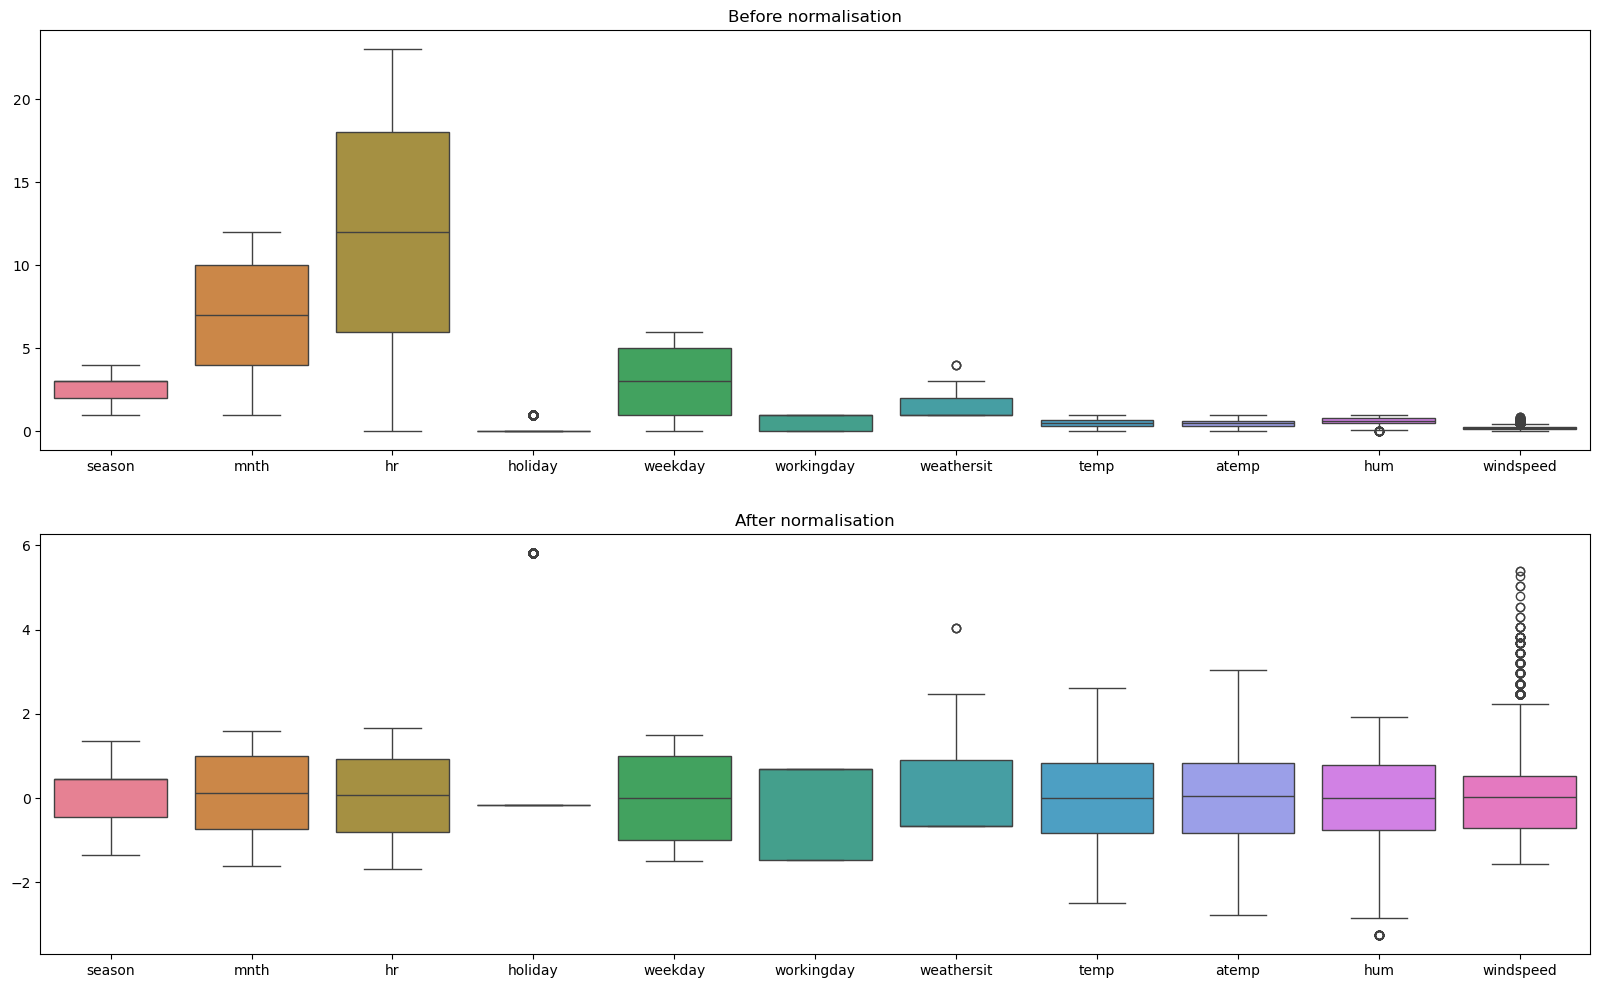

In [33]:
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

Xs = pd.DataFrame(Xs, columns=list(X.columns))

fig,ax=plt.subplots(2, 1,figsize=(20,12))
ax[0] = sns.boxplot(data=X, ax=ax[0])
ax[1] = sns.boxplot(data=Xs, ax=ax[1])
ax[0].set_title("Before normalisation")
ax[1].set_title("After normalisation")

### Split the data into training set and test set

In [34]:
X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size=0.2)

In [35]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(13903, 11)
(3476, 11)
(13903,)
(3476,)


### Feature selection

The cell below is just me being curious about which features the two `score_func`s consider to be the least important.

In [36]:
if curious_me:
  print(f"Upper: f_regression\nLower: mutual_info_regression")
  for i in range(0, 3):
    for k in range(10, 1, -1):
      for func in [f_regression, mutual_info_regression]:
        fs = SelectKBest(score_func=func, k=k)
        fs = fs.fit(X_train, y_train)

        X_train_new = fs.transform(X_train)
        X_test_new = fs.transform(X_test)

        features = X.columns.to_list()
        dropped_features = [feature for feature, retain in zip(features, fs.get_support()) if not retain]

        print(f"{dropped_features}")
      print()


Well... hmmmmm... I can't believe `holiday` is one of the least important features... And also, the least important features change every run.

### Create the model

#### Linear Regression Model, with normalised input.

This model is evaluated by K-fold cross validation. The score is the average of the k-fold. 

Also, a histogram shows the RMS error of the testing set.

*Note that the scoring is Neg-RMSE, so we multiply a negative to make it RMSE.*

Average RMSE of k-fold cross validation is 147.98078371000938


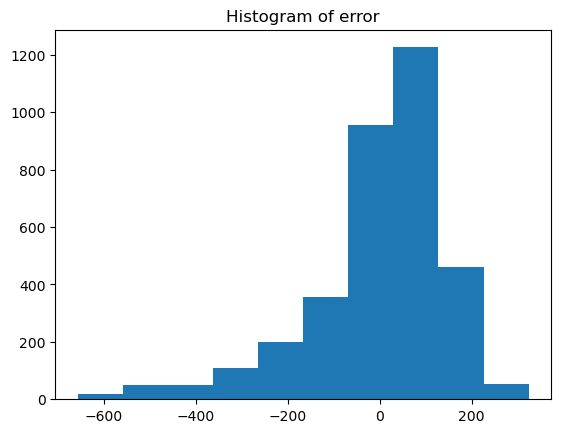

In [37]:
K = 7

model = LinearRegression()
model.fit(X_train, y_train)
score = cross_val_score(estimator=model, X=X_test, y=y_test, cv=K, scoring="neg_root_mean_squared_error")

y_predict = model.predict(X_test)

fig, ax = plt.subplots(1, 1)
ax.hist(y_predict - y_test)
ax.set_title("Histogram of error")

print(f"Average RMSE of k-fold cross validation is {-np.average(score)}")

#### Linear Regression Model, with RFE (Recursive Feature Elimination) and normalised input.

Just due to curiosity, we want to know which features the RFE considers less important.

In [38]:
model = LinearRegression()

rfe = RFE(estimator=model, n_features_to_select=5)

rfe = rfe.fit(X=X_train, y=y_train)

list(zip(X.columns,rfe.support_,rfe.ranking_))


[('season', True, 1),
 ('mnth', False, 7),
 ('hr', True, 1),
 ('holiday', False, 3),
 ('weekday', False, 4),
 ('workingday', False, 5),
 ('weathersit', False, 6),
 ('temp', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', False, 2)]

We can see the RFE considers `mnth`, `workingday` and `weathersit` are the least important features.

Now, we use Grid Search Cross Validation to find the best number of features.

In [27]:
# Create the models
model = LinearRegression()
model.fit(X=X_train, y=y_train)
rfe = RFE(estimator=model)

# setting the hyper-parameters we want to change in the k-fold thing
hyper_params = [{'n_features_to_select': list(range(1, len(X.columns)+1) ) }]

# create the cross validation thing
model_cv = GridSearchCV(estimator = rfe, param_grid = hyper_params, 
                        scoring= 'neg_root_mean_squared_error', 
                        cv = 5, return_train_score=True)

model_cv = model_cv.fit(X_train, y_train)


In [31]:
cv_results = pd.DataFrame(model_cv.cv_results_)

extracted_cv_results = cv_results[["param_n_features_to_select", "mean_test_score", "rank_test_score", "mean_train_score"]]
extracted_cv_results.loc[:, "mean_test_score"] = -extracted_cv_results["mean_test_score"]
extracted_cv_results.loc[:, "mean_train_score"] = -extracted_cv_results["mean_train_score"]
extracted_cv_results = extracted_cv_results.rename(columns={"mean_test_score": "mean_test_RMSE", "mean_train_score": "mean_train_RMSE"}, copy=False)
extracted_cv_results


,param_n_features_to_select,mean_test_RMSE,rank_test_score,mean_train_RMSE
0,1,166.572710,11,166.423005
1,2,154.652015,10,154.494157
2,3,149.378808,9,149.209857
3,4,148.384757,8,148.101353
4,5,147.915743,7,147.832298
5,6,147.863075,6,147.776021
6,7,147.853991,5,147.744878
7,8,147.848106,3,147.724546
8,9,147.839116,1,147.710844
9,10,147.849768,4,147.703120


### Try with Polynomial Regression
Hmmmm... Just a bit curious about how polynomial regression works.

In [117]:
# X: features, y: target

for degree in range(1, 4):
  print(f"{'*' * 20} Currently we are using degree of {degree} {'*' * 20}")
  poly = PolynomialFeatures(degree=degree)
  X_poly = poly.fit_transform(X, y)
  print(f"Number of features: {X_poly.shape[1]}")

  scaler = StandardScaler()
  X_poly_scaled = scaler.fit_transform(X_poly, y)
  if curious_me: 
    fig, ax = plt.subplots(1, 1)
    ax = sns.boxplot(X_poly_scaled)

  X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y, train_size=0.8)
  # print(f"Train: {X_train.shape} {y_train.shape}")
  # print(f"Test: {X_test.shape} {y_test.shape}")

  K = 5

  model = LinearRegression()
  
  score = cross_val_score(model, X_train, y_train, cv=K, scoring="neg_root_mean_squared_error")
  print(f"RMSE of training data: {-np.average(score)}")
  score = cross_val_score(model, X_test, y_test, cv=K, scoring="neg_root_mean_squared_error")
  print(f"RMSE of testing data: {-np.average(score)}")

  print("\nNow, use Recurrent Feature Elimination to find the best number of features")
  rfe = RFE(model)
  # setting the hyper-parameters we want to change in the k-fold thing
  hyper_params = [{'n_features_to_select': list(range(1, min(X_train.shape[1], 30) ) ) }]

  model_cv = GridSearchCV(estimator = rfe, param_grid = hyper_params, 
                          scoring= 'neg_root_mean_squared_error', 
                          cv = K, return_train_score=True)

  model_cv = model_cv.fit(X_train, y_train)

  print(f"Best n: {model_cv.best_params_}. Best score: {-model_cv.best_score_}")

  print("\nLet's see if the model overfits.")
  best_model = model_cv.best_estimator_
  score = cross_val_score(best_model, X_train, y_train, cv=K, scoring="neg_root_mean_squared_error")
  print(f"RMSE of training data: {-np.average(score)}")
  score = cross_val_score(best_model, X_test, y_test, cv=K, scoring="neg_root_mean_squared_error")
  print(f"RMSE of testing data: {-np.average(score)}")

  print("\n\n")

******************** Currently we are using degree of 1 ********************
Number of features: 12
RMSE of training data: 147.270442387005
RMSE of testing data: 148.4677517345304

Now, use Recurrent Feature Elimination to find the best number of features
Best n: {'n_features_to_select': 8}. Best score: 147.2588192836595

Let's see if the model overfits.
RMSE of training data: 147.2588192836595
RMSE of testing data: 148.47579241482407



******************** Currently we are using degree of 2 ********************
Number of features: 78
RMSE of training data: 129.79371850460947
RMSE of testing data: 138.36762655213994

Now, use Recurrent Feature Elimination to find the best number of features
Best n: {'n_features_to_select': 29}. Best score: 129.9846442667148

Let's see if the model overfits.
RMSE of training data: 129.9846442667148
RMSE of testing data: 137.3861284632949



******************** Currently we are using degree of 3 ********************
Number of features: 364
RMSE of trai

The above code runs for 3x minutes and outputs the following:

#### ******************** Currently we are using degree of 1 ********************

Number of features: 12

RMSE of training data: 147.270442387005

RMSE of testing data: 148.4677517345304


Now, use Recurrent Feature Elimination to find the best number of features

Best n: {'n_features_to_select': 8}. Best score: 147.2588192836595


Let's see if the model overfits.

RMSE of training data: 147.2588192836595

RMSE of testing data: 148.47579241482407





#### ******************** Currently we are using degree of 2 ********************

Number of features: 78

RMSE of training data: 129.79371850460947

RMSE of testing data: 138.36762655213994


Now, use Recurrent Feature Elimination to find the best number of features

Best n: {'n_features_to_select': 29}. Best score: 129.9846442667148


Let's see if the model overfits.

RMSE of training data: 129.9846442667148

RMSE of testing data: 137.3861284632949




#### ******************** Currently we are using degree of 3 ********************

Number of features: 364

RMSE of training data: 120.70579800652665

RMSE of testing data: 134.72643086964192


Now, use Recurrent Feature Elimination to find the best number of features

Best n: {'n_features_to_select': 29}. Best score: 127.4235463841272


Let's see if the model overfits.

RMSE of training data: 127.4235463841272

RMSE of testing data: 130.88249614393175


In [118]:
for degree in range(1, 6):
  print(f"{'*' * 20} Currently we are using degree of {degree} {'*' * 20}")
  poly = PolynomialFeatures(degree=degree)
  X_poly = poly.fit_transform(X, y)
  print(f"Number of features: {X_poly.shape[1]}")

  scaler = StandardScaler()
  X_poly_scaled = scaler.fit_transform(X_poly, y)
  if curious_me: 
    fig, ax = plt.subplots(1, 1)
    ax = sns.boxplot(X_poly_scaled)

  X_train, X_test, y_train, y_test = train_test_split(X_poly_scaled, y, train_size=0.8)
  # print(f"Train: {X_train.shape} {y_train.shape}")
  # print(f"Test: {X_test.shape} {y_test.shape}")

  K = 5

  model = LinearRegression()
  
  score = cross_val_score(model, X_train, y_train, cv=K, scoring="neg_root_mean_squared_error")
  print(f"RMSE of training data: {-np.average(score)}")
  score = cross_val_score(model, X_test, y_test, cv=K, scoring="neg_root_mean_squared_error")
  print(f"RMSE of testing data: {-np.average(score)}")


******************** Currently we are using degree of 1 ********************
Number of features: 12
RMSE of training data: 147.9899279784757
RMSE of testing data: 145.28219344793996
******************** Currently we are using degree of 2 ********************
Number of features: 78
RMSE of training data: 130.19835899862514
RMSE of testing data: 130.6852721325186
******************** Currently we are using degree of 3 ********************
Number of features: 364
RMSE of training data: 121.42994930629311
RMSE of testing data: 183.6754767279462
******************** Currently we are using degree of 4 ********************
Number of features: 1365
RMSE of training data: 11599625437.84904
RMSE of testing data: 352188436127.8024
******************** Currently we are using degree of 5 ********************
Number of features: 4368
RMSE of training data: 208004455612.15668
RMSE of testing data: 745348601804.0426


In the above cell, we can see that more features can cause overfitting and chaos.

## Assignment 1
The cell below is the model for submitting Assignment 1

In [119]:
from ucimlrepo import fetch_ucirepo 

import numpy as np

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from data_preprocessing import DataPreprocessing

# fetch dataset 
bike_sharing = fetch_ucirepo(id=275) 

# data (as pandas dataframes) 
X = bike_sharing.data.features 
y = bike_sharing.data.targets 

# convert y to shape of (samples, )
y = np.array(object=y)
y = y.ravel()

# Step 1: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

# Step 2: Define base_model
# Step 3: Data preprocessing
# Step 4: Create polynomial features
# Step 5: Normalisation
# Step 6: Use Recursive Feature Elimination + Linear Regression

base_model = LinearRegression()

pipe = Pipeline([('dropColumns', DataPreprocessing()),
                ('poly', PolynomialFeatures(degree=3)), 
                ('normalisation', StandardScaler(), ),
                ('rfe', RFE(estimator=base_model, n_features_to_select=30))])

K = 7
print(f"Calculating {K}-fold Negative-RMSE...")
score = cross_val_score(pipe, X_train, y_train, scoring="neg_root_mean_squared_error", cv=K)

print(f"Negative RMSE: {score}\n")
print(f"Average RMSE: {-np.average(score)}")  

Calculating 7-fold Negative-RMSE...
Negative RMSE: [-125.88678715 -127.45217759 -127.86294402 -124.76430563 -128.38410457
 -125.75152415 -127.23949513]

Average RMSE: 126.76304831989577


### Description of method

First, we load the bike sharing data using the `ucimlrepo` library. Then, we format the data into `features` and `target`, and split them into training and testing sets. After that, we drop features `dteday` and `yr`, which are irrelevent. Next, we apply `PolynomialFeatures` to the data, adding polynomial features up to a degree of 3. We normalise the data using `StandardScaler` to reduce the spread of the features and make them easier to use. Last, we use `LinearRegression` with `rfe` to perform linear regression and select important features with Recursive Feature Elimination. Finally, we implement 7-fold cross-validation to evaluate the root mean squared error (RMSE) of the model. 

### Parameter settings

- Polynomial Features: Degree of 3
- Recursive Feature Elimination (RFE): select 30 features
- Cross-validation Score: Negative Root Mean Squared Error
